In [240]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# # 현재 작업 디렉토리 설정 (주피터 노트북 환경에 맞게 수정하세요)
# os.chdir(r'/Users/juwonkim/Desktop/4학년 1학기/데이터마이닝/프로젝트')
# print(f"Current working directory: {os.getcwd()}")

# # 파일 존재 여부 확인
# data_dir = 'data'
# file_path = os.path.join(data_dir, 'commodities', 'BrentOil.csv')
# print(f"Expected file path: {file_path}")
# print(f"File exists: {os.path.exists(file_path)}")

# SYMBOLS = ['BrentOil', 'Copper', 'CrudeOil', 'Gasoline', 'Gold', 'NaturalGas', 'Platinum', 'Silver',
#            'AUD', 'CNY', 'EUR', 'GBP', 'HKD', 'JPY', 'USD'] 


In [241]:
os.chdir(r'/Users/juwonkim/Desktop/4학년 1학기/데이터마이닝/프로젝트')
print(f"Current working directory: {os.getcwd()}")

# 데이터 디렉토리 설정
data_dir = 'data'

# 데이터 디렉토리 내의 파일들을 확인합니다.
print("Data directory contains:", os.listdir(data_dir))

Current working directory: /Users/juwonkim/Desktop/4학년 1학기/데이터마이닝/프로젝트
Data directory contains: ['NaturalGas.csv', 'Gold.csv', 'Platinum.csv', '.DS_Store', 'CrudeOil.csv', 'Silver.csv', 'AUD.csv', 'CNY.csv', 'Copper.csv', 'EUR.csv', 'HKD.csv', 'USD.csv', 'JPY.csv', 'GBP.csv', 'BrentOil.csv', 'Gasoline.csv', 'all_130101_231027.pkl']


In [242]:
SYMBOLS = ['BrentOil', 'Copper', 'CrudeOil', 'Gasoline', 'Gold', 'NaturalGas', 'Platinum', 'Silver',
           'AUD', 'CNY', 'EUR', 'GBP', 'HKD', 'JPY', 'USD'] 


# EDA

In [243]:
def preprocess_data(table, in_columns, out_columns):
    # 결측치 선형보간법 사용해서 처리
    table.dropna(inplace=True, subset=['USD_Price', 'Gold_Price', 'Silver_Price'])
    table.interpolate(method='linear', inplace=True)
    # table = table[~table.index.year.isin([2020])]
    # table = table[~table.index.year.isin([2021])]

    if 'USD_Price' not in out_columns:
        raise ValueError('USD_Price must be included in out_columns')

    use_columns = list(set(in_columns + out_columns))
    df = table[use_columns]

    #새로운 파생변수 MACD 사용
    def calculate_macd(data, short_window, long_window, signal_window):
        short_ema = data.ewm(span=short_window, adjust=False).mean()
        long_ema = data.ewm(span=long_window, adjust=False).mean()
        macd = short_ema - long_ema
        signal_line = macd.ewm(span=signal_window, adjust=False).mean()
        return macd, signal_line

    df['MACD'], df['Signal_Line'] = calculate_macd(df['USD_Price'], short_window=12, long_window=26, signal_window=9)
    in_columns.extend(['MACD', 'Signal_Line'])
    #새로운 파생변서 RSI 사용
    def calculate_rsi(data, window):
        delta = data.diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        rs = up.rolling(window=window).mean() / down.abs().rolling(window=window).mean()
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['RSI'] = calculate_rsi(df['USD_Price'], window=14)
    df['RSI'] = df['RSI'].interpolate(method='linear', limit_direction='both')
    in_columns.append('RSI')

    def calculate_volatility(data, window):
        return data.rolling(window=window).std()
    #새로운 파생변수 변동성 사용
    df['Volatility'] = calculate_volatility(df['USD_Price'], window=20)
    df['Volatility'] = df['Volatility'].interpolate(method='linear', limit_direction='both')
    in_columns.append('Volatility')

    print(df.shape)
    print(df.head())
    missing_values = df.isnull().sum()
    print(missing_values)
    total_missing_columns = missing_values[missing_values > 0].count()
    print(f"Number of columns with missing values: {total_missing_columns}")
    total_missing_rows = df.isnull().any(axis=1).sum()
    print(f"Number of rows with missing values: {total_missing_rows}")

    return df
    # # input_days 만큼의 과거 데이터를 사용하여 다음날의 USD_Price를 예측하도록 데이터셋 구성됨

    # date_indices = sorted(table.index)
    # #print(date_indices)
    # x = np.asarray([df.loc[date_indices[i:i + input_days], in_columns] for i in range(len(df) - input_days)])
    # y = np.asarray([df.loc[date_indices[i + input_days], out_columns] for i in range(len(df) - input_days)])


    # # 최근 10일을 test set으로 사용
    # # 주의 : 검증 및 테스트 과정에 반드시 최근 10일 데이터를 사용해야 하므로 수정하지 말 것
    # training_x, test_x = x[:-10], x[-10:]  # !!! 수정 금지 !!!
    # training_y, test_y = y[:-10], y[-10:]  # !!! 수정 금지 !!!

        
    # return (training_x, training_y) if is_training else (test_x, test_y)



In [244]:
def merge_data(start_date, end_date, symbols, data_dir='data'):
    dates = pd.date_range(start_date, end_date, freq='D')
    
    df = pd.DataFrame(index=dates)


    if 'USD' not in symbols:
        symbols.insert(0, 'USD')

    for symbol in symbols:
        df_temp = pd.read_csv(get_data_path(symbol, data_dir), index_col="Date", parse_dates=True, na_values=['nan'])
        df_temp = df_temp.reindex(dates)
        df_temp.columns = [symbol + '_' + col for col in df_temp.columns]
        df = df.join(df_temp)

    return df


In [245]:
# 데이터 로드 및 전처리 테스트
start_date = '2013-01-01'
end_date = '2023-10-27'
input_days = 3
# in_columns = ['USD_Price', 'Gold_Price', 'Silver_Price']
in_columns=['USD_Price','BrentOil_Price', 'Copper_Price', 'CrudeOil_Price', 'Gasoline_Price', 'Gold_Price', 
                             'NaturalGas_Price', 'Platinum_Price', 'Silver_Price', 'AUD_Price', 
                             'CNY_Price', 'EUR_Price', 'GBP_Price', 'HKD_Price', 'JPY_Price']
out_columns = ['USD_Price']



In [246]:
def get_data_path(symbol, data_dir):
    file_path = os.path.join(data_dir,f'{symbol}.csv')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No data file found for symbol: {symbol}")
    return file_path

In [247]:
# 데이터 병합
table = merge_data(start_date, end_date, symbols=SYMBOLS, data_dir=data_dir)



In [248]:
# 데이터 전처리
df = preprocess_data(table, in_columns, out_columns)

(2780, 19)
            Gold_Price  CNY_Price  HKD_Price  BrentOil_Price  GBP_Price  \
2013-01-02      1688.8     170.70    137.210          112.47    1728.61   
2013-01-03      1674.6     170.65    137.175          112.14    1711.86   
2013-01-04      1648.9     170.51    137.075          111.31    1707.05   
2013-01-07      1646.3     170.68    137.140          111.40    1713.07   
2013-01-08      1662.2     170.97    137.295          111.94    1708.60   

            USD_Price  EUR_Price  Copper_Price  JPY_Price  NaturalGas_Price  \
2013-01-02    1063.50    1402.38        3.7360    12.1898             3.233   
2013-01-03    1063.20    1387.43        3.7170    12.1864             3.198   
2013-01-04    1062.39    1388.70        3.6935    12.0486             3.287   
2013-01-07    1063.21    1394.12        3.6780    12.1059             3.266   
2013-01-08    1064.15    1392.49        3.6720    12.2155             3.218   

            AUD_Price  Silver_Price  Gasoline_Price  CrudeOil_P

/var/folders/jk/7yn2gh2d6xl2nb2cbhp3pdtw0000gn/T/ipykernel_7003/3616074272.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'], df['Signal_Line'] = calculate_macd(df['USD_Price'], short_window=12, long_window=26, signal_window=9)
/var/folders/jk/7yn2gh2d6xl2nb2cbhp3pdtw0000gn/T/ipykernel_7003/3616074272.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'], df['Signal_Line'] = calculate_macd(df['USD_Price'], short_window=12, long_window=26, signal_window=9)
/var/folders/jk/7yn2gh2d6xl2

In [249]:
df

,Gold_Price,CNY_Price,HKD_Price,BrentOil_Price,GBP_Price,USD_Price,EUR_Price,Copper_Price,JPY_Price,NaturalGas_Price,AUD_Price,Silver_Price,Gasoline_Price,CrudeOil_Price,Platinum_Price,MACD,Signal_Line,RSI,Volatility
2013-01-02,1688.8,170.70,137.210,112.47,1728.61,1063.50,1402.38,3.7360,12.1898,3.233,1116.36,31.007,2.7951,93.12,1571.50,0.000000,0.000000,50.386473,9.274339
2013-01-03,1674.6,170.65,137.175,112.14,1711.86,1063.20,1387.43,3.7170,12.1864,3.198,1112.26,30.720,2.7977,92.92,1555.15,-0.023932,-0.004786,50.386473,9.274339
2013-01-04,1648.9,170.51,137.075,111.31,1707.05,1062.39,1388.70,3.6935,12.0486,3.287,1113.60,29.946,2.7643,93.09,1560.80,-0.107024,-0.025234,50.386473,9.274339
2013-01-07,1646.3,170.68,137.140,111.40,1713.07,1063.21,1394.12,3.6780,12.1059,3.266,1116.32,30.082,2.7774,93.19,1561.10,-0.105492,-0.041286,50.386473,9.274339
2013-01-08,1662.2,170.97,137.295,111.94,1708.60,1064.15,1392.49,3.6720,12.2155,3.218,1117.73,30.465,2.7944,93.15,1582.35,-0.028104,-0.038649,50.386473,9.274339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-23,1978.2,183.45,171.540,88.69,1643.83,1342.12,1431.77,3.5865,8.9636,2.926,850.23,23.095,2.3116,85.49,905.00,3.819118,4.954530,35.757212,5.600977
2023-10-24,1986.1,183.82,171.770,87.16,1634.02,1343.88,1422.90,3.6240,8.9640,2.971,854.04,23.116,2.2527,83.74,891.90,3.170452,4.597715,43.425076,5.706226
2023-10-25,1994.9,184.81,172.900,89.12,1637.94,1352.44,1428.58,3.5910,9.0007,3.010,853.12,23.007,2.2688,85.39,912.40,3.308957,4.339963,55.461638,5.625966
2023-10-26,1997.4,184.88,172.960,87.05,1640.27,1352.69,1428.44,3.5845,8.9934,3.214,855.04,22.908,2.2371,83.21,909.00,3.399706,4.151912,56.660073,5.676216


In [250]:
missing_values = df.isnull().sum()
print(missing_values)

Gold_Price          0
CNY_Price           0
HKD_Price           0
BrentOil_Price      0
GBP_Price           0
USD_Price           0
EUR_Price           0
Copper_Price        0
JPY_Price           0
NaturalGas_Price    0
AUD_Price           0
Silver_Price        0
Gasoline_Price      0
CrudeOil_Price      0
Platinum_Price      0
MACD                0
Signal_Line         0
RSI                 0
Volatility          0
dtype: int64


In [251]:
# 전체 데이터에서 결측치가 있는 컬럼의 수를 확인
total_missing_columns = missing_values[missing_values > 0].count()
print(f"Number of columns with missing values: {total_missing_columns}")

# 결측치가 있는 행의 수를 확인
total_missing_rows = df.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {total_missing_rows}")

Number of columns with missing values: 0
Number of rows with missing values: 0


In [252]:
print(df.corr())


                  Gold_Price  CNY_Price  HKD_Price  BrentOil_Price  GBP_Price  \
Gold_Price          1.000000   0.412655   0.575581        0.183940  -0.114425   
CNY_Price           0.412655   1.000000   0.692030        0.302106   0.501667   
HKD_Price           0.575581   0.692030   1.000000       -0.067335  -0.034525   
BrentOil_Price      0.183940   0.302106  -0.067335        1.000000   0.409093   
GBP_Price          -0.114425   0.501667  -0.034525        0.409093   1.000000   
USD_Price           0.573890   0.682073   0.998011       -0.051441  -0.061127   
EUR_Price           0.409781   0.383374   0.158263        0.628050   0.516003   
Copper_Price        0.726117   0.433660   0.227326        0.592615   0.086928   
JPY_Price           0.089841  -0.217485  -0.167272       -0.057993  -0.145782   
NaturalGas_Price    0.210416   0.456218   0.210383        0.639540   0.163154   
AUD_Price          -0.031268   0.252749  -0.198722        0.682626   0.553072   
Silver_Price        0.760878

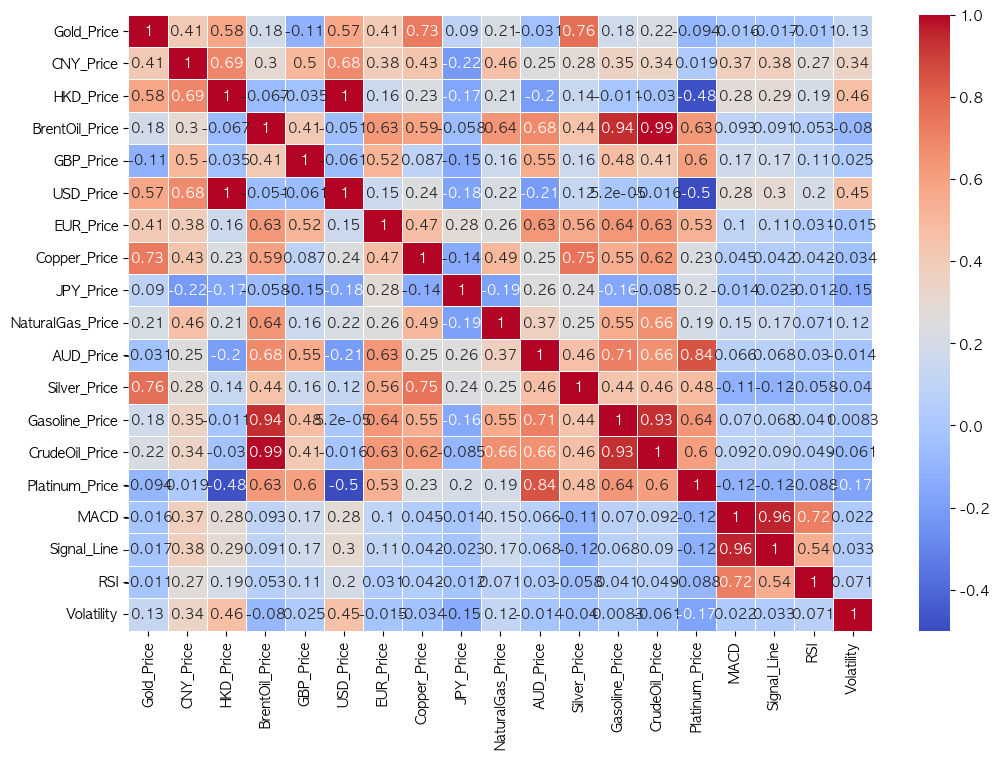

In [253]:
#상관관계 시각화
plt.figure(figsize=(12, 8))  # 히트맵의 크기 설정
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()
#plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

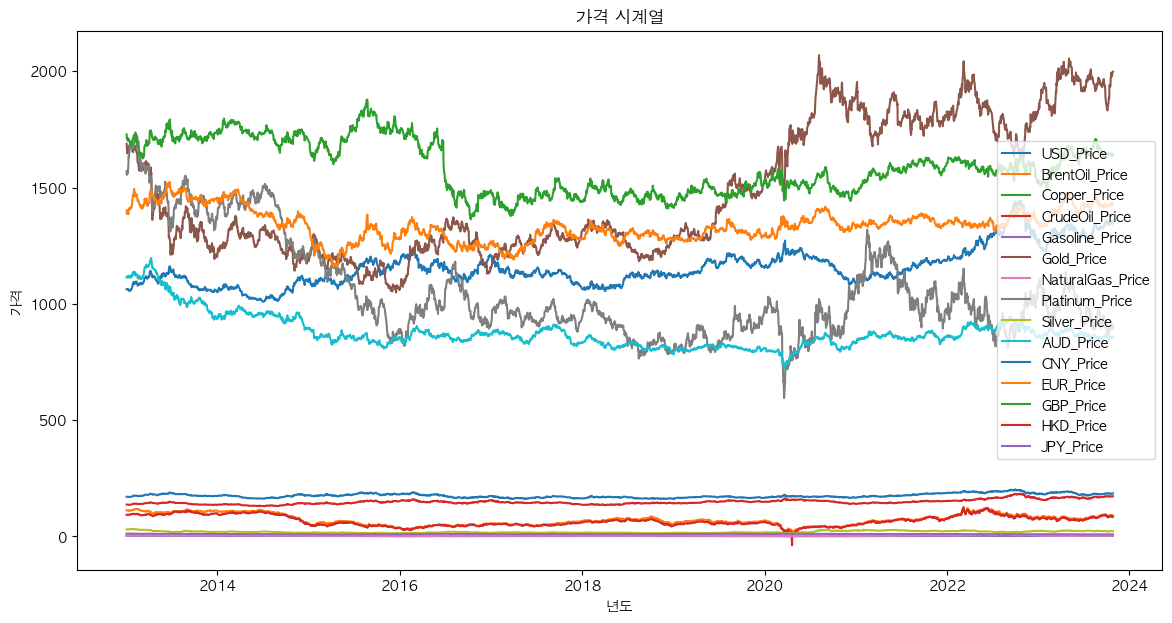

In [254]:
plt.figure(figsize=(14, 7))
for col in in_columns:
    if 'Price' in col:
        plt.plot(df[col], label=col)
plt.title('가격 시계열')
plt.xlabel('년도')
plt.ylabel('가격')
plt.legend()
plt.show()

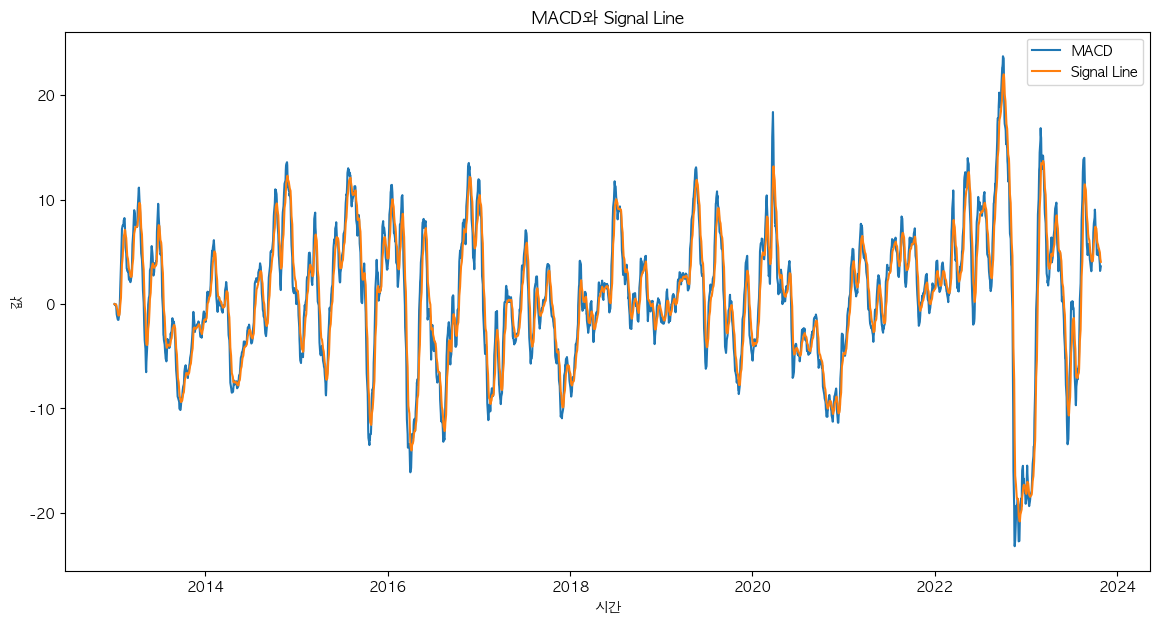

In [255]:
# 시각화 - MACD와 Signal Line
plt.figure(figsize=(14, 7))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['Signal_Line'], label='Signal Line')
plt.title('MACD와 Signal Line')
plt.xlabel('시간')
plt.ylabel('값')
plt.legend()
plt.show()



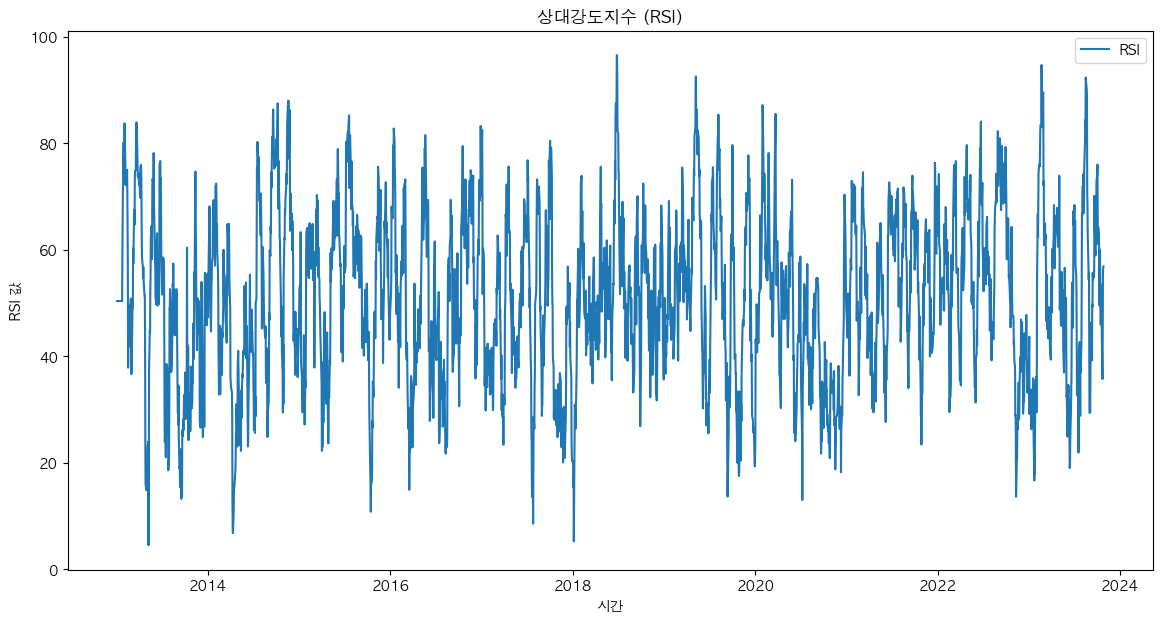

In [256]:
# 시각화 - RSI
plt.figure(figsize=(14, 7))
plt.plot(df['RSI'], label='RSI')
plt.title('상대강도지수 (RSI)')
plt.xlabel('시간')
plt.ylabel('RSI 값')
plt.legend()
plt.show()



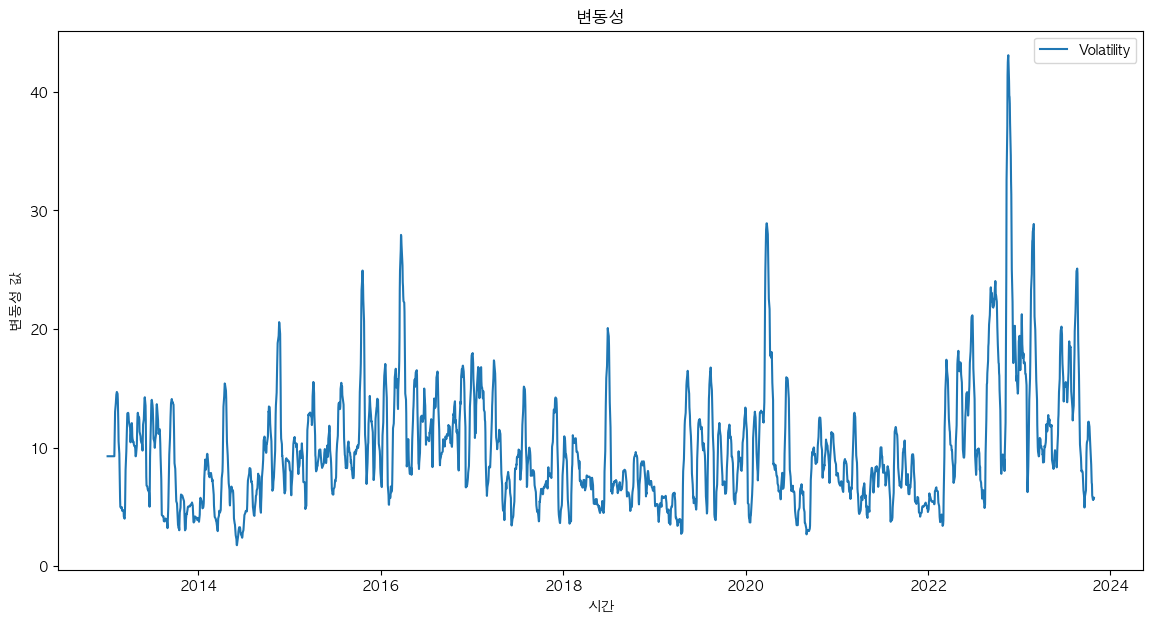

In [257]:
# 시각화 - 변동성
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='Volatility')
plt.title('변동성')
plt.xlabel('시간')
plt.ylabel('변동성 값')
plt.legend()
plt.show()

# Modeling

In [258]:
class PriceDataset:
    def __init__(self, start_date, end_date, input_days=3, data_dir='data'):
        self.input_days = input_days
        self.X, self.y = self.make_dataset(start_date, end_date, data_dir)

In [259]:
from sklearn.model_selection import train_test_split

In [260]:
start_date = '2013-01-01'
end_date = '2023-10-27'
input_days = 3

In [261]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split



df['USD_Price_Target'] = df['USD_Price'].shift(-1)

# 마지막 행 삭제 (타겟 값이 NaN이 됨)
df.dropna(inplace=True)

# 특징과 타겟 분할
X = df.drop(columns=['USD_Price_Target'])  # 타겟 열 제외
y = df['USD_Price_Target']   # 타겟 열

# 시계열 데이터 분할
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# 학습 데이터와 테스트 데이터로만 분리
train_dataset = (X_train_val.iloc[:-10], y_train_val.iloc[:-10])
test_dataset = (X_test, y_test)


/var/folders/jk/7yn2gh2d6xl2nb2cbhp3pdtw0000gn/T/ipykernel_7003/2307546395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['USD_Price_Target'] = df['USD_Price'].shift(-1)
/var/folders/jk/7yn2gh2d6xl2nb2cbhp3pdtw0000gn/T/ipykernel_7003/2307546395.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [262]:
train_dataset

(            Gold_Price  CNY_Price  HKD_Price  BrentOil_Price  GBP_Price  \
 2013-01-02      1688.8     170.70    137.210          112.47    1728.61   
 2013-01-03      1674.6     170.65    137.175          112.14    1711.86   
 2013-01-04      1648.9     170.51    137.075          111.31    1707.05   
 2013-01-07      1646.3     170.68    137.140          111.40    1713.07   
 2013-01-08      1662.2     170.97    137.295          111.94    1708.60   
 ...                ...        ...        ...             ...        ...   
 2022-09-12      1740.6     198.39    175.140           94.00    1605.57   
 2022-09-13      1717.4     201.35    177.670           93.17    1602.63   
 2022-09-14      1709.1     199.77    177.210           94.10    1604.39   
 2022-09-15      1677.3     199.90    178.160           90.84    1603.14   
 2022-09-16      1683.5     198.39    176.410           91.35    1580.30   
 
             USD_Price  EUR_Price  Copper_Price  JPY_Price  NaturalGas_Price  \
 2013-

In [263]:
test_dataset

(            Gold_Price  CNY_Price  HKD_Price  BrentOil_Price  GBP_Price  \
 2022-10-03      1702.0     201.37     182.61           88.86    1622.52   
 2022-10-04      1730.5     198.85     180.33           91.80    1624.04   
 2022-10-05      1720.8     198.88     180.34           93.37    1603.42   
 2022-10-06      1720.8     197.84     179.40           94.42    1571.39   
 2022-10-07      1709.3     198.85     180.32           97.92    1568.95   
 ...                ...        ...        ...             ...        ...   
 2023-10-20      1994.4     184.37     172.42           92.16    1640.48   
 2023-10-23      1978.2     183.45     171.54           88.69    1643.83   
 2023-10-24      1986.1     183.82     171.77           87.16    1634.02   
 2023-10-25      1994.9     184.81     172.90           89.12    1637.94   
 2023-10-26      1997.4     184.88     172.96           87.05    1640.27   
 
             USD_Price  EUR_Price  Copper_Price  JPY_Price  NaturalGas_Price  \
 2022-

In [264]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

model = DecisionTreeRegressor()

X_train, y_train = train_dataset
X_test, y_test = test_dataset

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 693.2375258992816
Mean Absolute Error: 21.583165467625918


In [268]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

X_train, y_train = train_dataset
X_test, y_test = test_dataset

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 79.16510003257956
Mean Absolute Error: 7.004850072535503
